In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import dask.array as da
from joblib import Parallel, delayed

# Doing this for several values of zonostrophy



# Periodic case

In [3]:
#################################################################Aide de Chat GPT########################################################################""


def fft2d_RI_vect_optimized(psi, Lx, nx, ny, time_tab):
    real_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    imag_part_tab = np.zeros((len(time_tab), ny, nx), dtype=float)
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    
    Kx, Ky = np.meshgrid(kx, ky)

    for i, time_sel in enumerate(time_tab):
        psi_data = psi[time_sel, :, :]
        fft_result = np.fft.fft2(psi_data) * 2 / (nx * ny)
        
        real_part_tab[i, :, :] = np.real(fft_result)
        imag_part_tab[i, :, :] = np.imag(fft_result)

    return real_part_tab, imag_part_tab, Kx, Ky

def fft2d_RI(psi, Lx, nx, ny):
    
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
    

    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi) / (nx * ny)  
    fft_shifted = np.fft.fftshift(fft_result,axes=(1,2))  # Shift zero frequency component to center

    print(np.shape(fft_shifted))
    return fft_shifted, Kx, Ky



def pulsation_vect_optimized(real_part_tab, imag_part_tab, t,time_tab):
    dt = t[time_tab[1]] - t[time_tab[0]]
    count = real_part_tab.shape[0] - 1

    pulsation_sum = np.zeros_like(real_part_tab[0], dtype=complex)
    pulsation_var = np.zeros_like(real_part_tab[0], dtype=complex)
    for t in range(count):
        real_t, imag_t = real_part_tab[t], imag_part_tab[t]
        real_t1, imag_t1 = real_part_tab[t + 1], imag_part_tab[t + 1]
        
        amp_t = np.sqrt(real_t**2 + imag_t**2)
        psi_t = (real_t + 1j * imag_t) / np.max(amp_t)
        
        amp_t1 = np.sqrt(real_t1**2 + imag_t1**2)
        psi_t1 = (real_t1 + 1j * imag_t1) / np.max(amp_t1)

        psi_conj_interp = (np.conjugate(psi_t1) + np.conjugate(psi_t)) / 2
        psi_norm_interp = (amp_t + amp_t1) / 2

        dreal_dt = (real_t1 - real_t) / dt
        dimag_dt = (imag_t1 - imag_t) / dt
        pterm = psi_conj_interp * (dreal_dt + 1j * dimag_dt)

        psi_squared_t = real_t**2 + imag_t**2
        psi_squared_t1 = real_t1**2 + imag_t1**2
        sterm = (psi_squared_t1 - psi_squared_t) / dt

        pulsation_t = 1 / (1j * psi_norm_interp) * (pterm - sterm)
        pulsation_sum += np.abs(pulsation_t)
        pulsation_var += pulsation_t**2

    pulsation_observed_mean = pulsation_sum / count
    pulsation_var = pulsation_var / count 
    return pulsation_observed_mean, pulsation_var



la simulation chargée est: dahu_901
depuis: dahu
{'NX': 1024.0, 'NY': 1024.0, 'nl': 1.0, 'Lx': 209.43951023931956, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.0007716049382716049, 'n_hyper': 4.0, 'hEkb': 0.0016000000000000003, 'tend': 1576800000000.0, 'dt_out': 10.0}


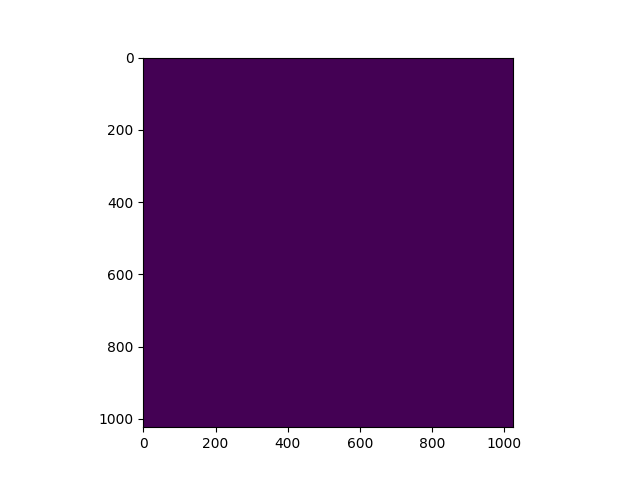

In [25]:


# Number of simulation
n = 901

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
#dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})
dataset=nc.Dataset(Path+filenames[0])

# # Load variables in chunks
# t = dataset['time'].data
# x = dataset['x'].data
# y = dataset['y'].data
# psi = dataset['psi'].isel(level=0).data
# q = dataset['q'].isel(level=0).data
# print("shape of psi :",np.shape(psi))


t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,0,:,:]
q=dataset.variables['q'][:,0,:,:]
# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 256
    ny = 256
    
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



<class 'numpy.ma.core.MaskedArray'>
(70, 1024, 1024)
(-0.0011775892897276186+3.458190480210869e-21j)
(70, 1024, 1024)
shape fft mean (1024, 1024)
k_rhines = 0.2
Zono = 5.0
Occupation = 0.15
(1024, 1024)
u (70, 1024, 1024)
mean total energy 1208.670500997118
sum of the mean total fluc and mean energy 1208.6705027486896


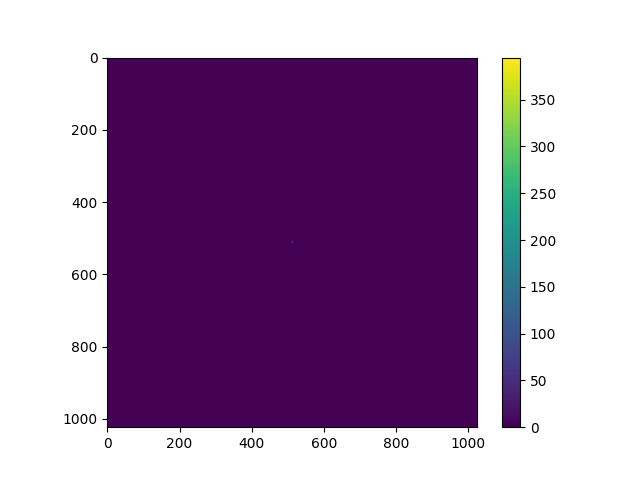

In [5]:
#Computing the energy contain in the rossby waves
time_sel = np.arange(1, len(t), 5)
print(type(psi))



psi_mean=np.mean(psi[time_sel,:,:],axis=0)

fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)
print(np.mean(fft,axis=(0,1,2)))
fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
fft_mean = np.mean(fft,axis=0)
print("shape fft mean",np.shape(fft_mean))
#Computing k_rhines and useful parameters

epsilon = sigma_f**2
r = hEkb
k_rhines = beta**0.5/(epsilon/r)**(1/4)
Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)

print('k_rhines =',k_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n = Lx*(k_rhines)/(2*np.pi)
dx = x[-1]-x[-2]

# Compute the energy spectrums
energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)


# Compute the magnitude of the wave numbers
k_mag = np.sqrt(Kx**2 + Ky**2)

# # mask = np.zeros_like(k_mag)
# # mask[k_mag<k_rhines]=1
# mask = np.ones_like(k_mag)
# # Filter out the energies for k < krhines
# energy_filtered = energy_mat*mask

# Sum the total energy for the filtered values
total_energy_rhines_fft = np.sum(energy_mat,axis=(1,2))

print(np.shape(psi_mean))
u,v=op.calc_uv(psi[time_sel,:,:],dx,bc_fac)
u_mean,v_mean=op.calc_uv(psi_mean[None,:,:],dx,bc_fac)

print("u",np.shape(u))
total_energy_rhines = np.mean(0.5 * ( (u)**2 + (v)**2 ),axis=(1,2))#op.calc_en(psi[time_sel,:,:]-psi_mean,q[time_sel,:,:]-q_mean,dx,bc_fac=bc_fac)/Lx**2

##

#Calculating the total energy
#psi_fluc=psi[time_sel,:,:]-np.mean(psi[time_sel,:,:],axis=0)
#q_fluc=q[time_sel,:,:]-np.mean(q[time_sel,:,:],axis=0)
#total_energy_rhines=np.sum(psi_fluc*q_fluc,axis=(1,2))
#energy_totale=op.calc_en(psi[time_sel,:,:], q[time_sel,:,:],dx,bc_fac=bc_fac)/Lx**2
#energy_totale_fft,_,_= fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)

#energy_ratio=total_energy_rhines/np.mean(energy_totale,axis=0)
#energy_ratio_fft=total_energy_rhines_fft/np.mean(energy_totale,axis=0)/2
# Plot the total energy
# plt.figure()
# plt.subplot(211)
# plt.plot(time_sel,total_energy_rhines)
# plt.xlabel('Time')
# plt.ylabel('Energy below k_rhines / Total Energy')
# plt.title('Energy ratio for $\\sqrt{Kx^2 + Ky^2} < krhines$')
# plt.subplot(212)
# plt.plot(time_sel,total_energy_rhines_fft/2)
# plt.show()
total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)
total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
print("mean total energy",total_mean_energy_fft)
print("sum of the mean total fluc and mean energy",total_mean_energy_fluc_fft+total_mean_energy_fft_mean)
plt.figure()
plt.imshow(np.abs(fft_mean))
plt.colorbar()
plt.show()

(4, 1024, 1024)
(-1.4551915235970606e-11+4.373282189115746e-21j)
(4, 1024, 1024)
k_rhines = 0.2
Zono = 5.0
Occupation = 0.15


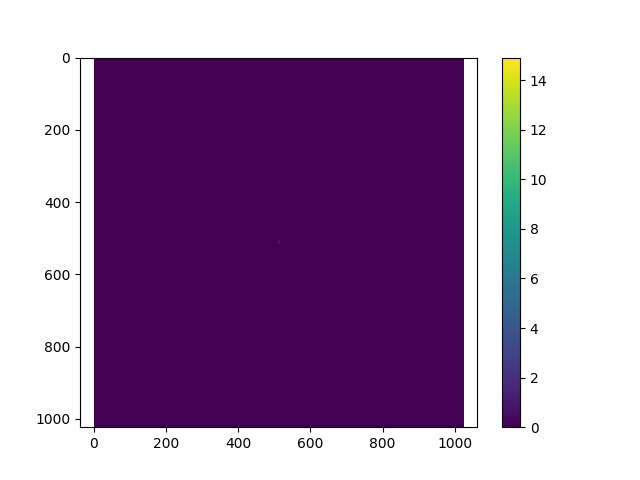

mean total energy in the waves 74.1147423730815
ratio of the mean total energy in the waves and the total energy 0.8378504811691256
energy in the mean flow/total energy 1.9754523827788526e-10


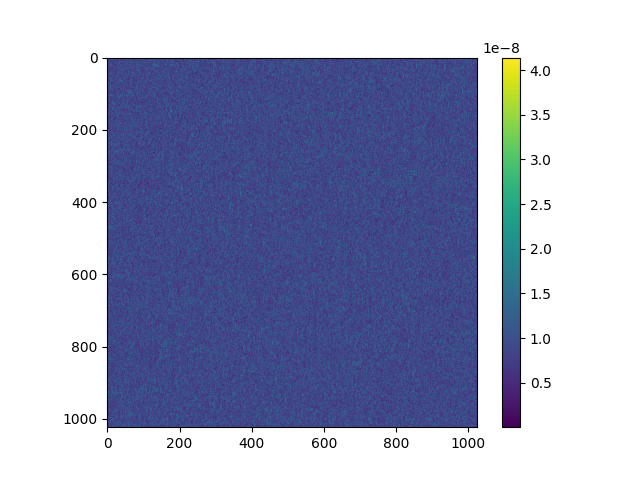

In [6]:
#Computing the energy contain in the rossby waves
time_sel = np.arange(len(t)-20, len(t), 5)
psi_mean=np.mean(psi[time_sel,:,:],axis=0)

fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean,Lx,nx,ny)
print(np.mean(fft,axis=(0,1,2)))
fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
fft_mean = np.mean(fft,axis=0)

#Computing k_rhines and useful parameters

epsilon = sigma_f**2
r = hEkb
k_rhines = beta**0.5/(epsilon/r)**(1/4)
Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)

print('k_rhines =',k_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n = Lx*(k_rhines)/(2*np.pi)
dx = x[-1]-x[-2]

# Compute the energy spectrums
energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)


# Compute the magnitude of the wave numbers
k_mag = np.sqrt(Kx**2 + Ky**2)

mask = np.zeros_like(k_mag)
mask[(k_mag<k_rhines) ]=1 #| (Kx==0) 

# Filter out the energies for k < krhines
energy_filtered = energy_mat*mask
plt.figure()
plt.imshow(np.mean(energy_filtered,axis=0))
plt.colorbar()#np.mean(energy_filtered,axis=0))
plt.axis('equal')
plt.show()

# Sum the total energy for the filtered values
total_energy_rhines_fft = np.mean(np.sum(energy_filtered,axis=(1,2)),axis=0)
total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)
total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))

print("mean total energy in the waves",total_energy_rhines_fft)
print("ratio of the mean total energy in the waves and the total energy",total_energy_rhines_fft/total_mean_energy_fft)
print("energy in the mean flow/total energy",total_mean_energy_fft_mean/total_mean_energy_fft)

plt.figure()
plt.imshow(np.abs(fft_mean))
plt.colorbar()
plt.show()

jet oscillations account for rossby waves the take part in the budget

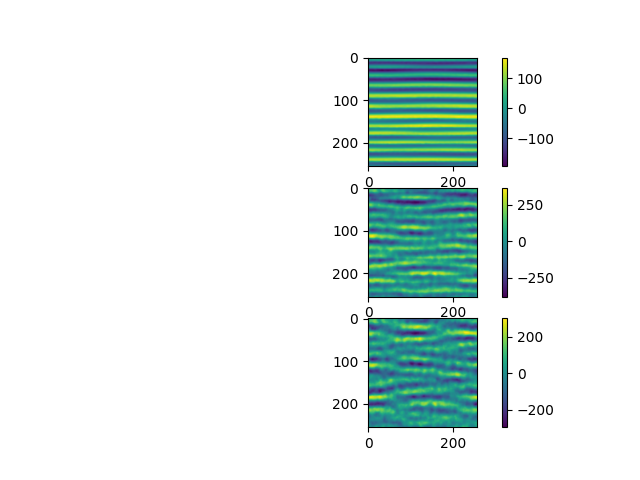

In [6]:
plt.figure()
plt.subplot(311)
plt.imshow(psi_mean)
plt.colorbar()
plt.subplot(312)
plt.imshow(psi[4,:,:])
plt.colorbar()
plt.subplot(313)
plt.imshow(psi[4,:,:]-psi_mean)
plt.colorbar()
plt.show()

(280, 256, 256)
(256, 256)
(280, 256, 256)
[[ 2.2070749e-06  1.2980188e-05  9.8773413e-08 ... -1.2969971e-05
  -5.4631914e-06  5.1089696e-06]
 [ 7.3739460e-07 -1.2866088e-06  2.5715146e-06 ...  3.3991678e-06
  -4.9318587e-06 -8.7261196e-06]
 [ 6.6893440e-06  1.2431826e-06  1.4458384e-06 ... -1.7370496e-07
  -5.9945245e-07  1.8869127e-06]
 ...
 [-1.9618444e-06 -3.0381339e-05  1.0899136e-06 ... -5.1770890e-06
   4.3051582e-06 -1.6512189e-05]
 [ 4.9591063e-06  5.7220459e-06  4.6048845e-06 ... -4.5503889e-06
   1.3160706e-05  2.0163399e-05]
 [ 1.5939985e-06 -1.2016297e-05  2.9018947e-06 ...  5.3950716e-06
  -1.2234279e-05 -3.4059798e-07]]


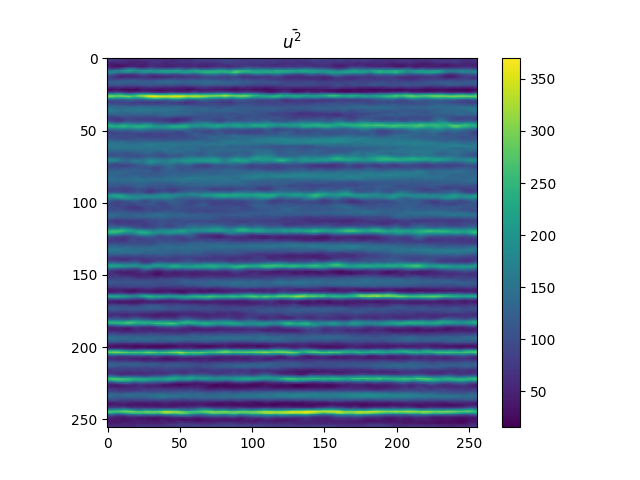

In [7]:
print(np.shape(psi[time_sel,:,:]))
print(np.shape(psi_mean))
print(np.shape(psi[time_sel,:,:]-psi_mean))
print(np.mean(psi[time_sel,:,:]-psi_mean,axis=0))
plt.figure()
plt.imshow(np.mean(1/2*(u**2+v**2),axis=0))
plt.colorbar()
plt.title(r'$\bar{u^2}$')
plt.show()

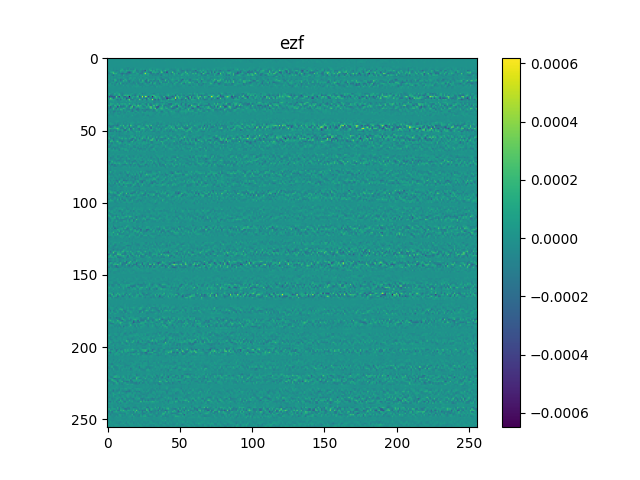

In [8]:

plt.figure()
plt.imshow(np.mean(1/2*(u**2+v**2),axis=0)-1/2* ( u_mean[0,:,:]**2+v_mean[0,:,:]**2 + np.mean(((u-u_mean[0,:,:])**2+(v-v_mean[0,:,:])**2),axis=0) ))
plt.colorbar()
plt.title(r'ezf')
plt.show()

In [4]:
simu_numbers=np.array([59,51,63,64,65,68,70,69,68,6190,901]) #Zonostrophic simu
t_conv=np.array([200,300,200,350,1300,300,-200,300,300,30,600])
where_list =  ['dahu' for i in range(len(simu_numbers))]


#Arrays where I will store the parameters:


Zo_tab_l=np.zeros_like(simu_numbers,dtype='float')
Oc_tab_l=np.zeros_like(simu_numbers,dtype='float')
E_wave_tab=np.zeros_like(simu_numbers,dtype='float')
E_meanflow_tab=np.zeros_like(simu_numbers,dtype='float')
E_turb_tab=np.zeros_like(simu_numbers,dtype='float')


f0_tab=np.zeros_like(simu_numbers,dtype='float')
beta_tab=np.zeros_like(simu_numbers,dtype='float')
hEkb_tab=np.zeros_like(simu_numbers,dtype='float')
dh_tab=np.zeros_like(simu_numbers,dtype='float')
Lx_tab=np.zeros_like(simu_numbers,dtype='float')
nx_tab=np.zeros_like(simu_numbers,dtype='float')
ny_tab=np.zeros_like(simu_numbers,dtype='float')
sigma_f_tab=np.zeros_like(simu_numbers,dtype='float')
bc_fac_tab=np.zeros_like(simu_numbers,dtype='float')
nu_hyper_tab=np.zeros_like(simu_numbers,dtype='float')
n_hyper_tab=np.zeros_like(simu_numbers,dtype='float')





for i,n in enumerate(simu_numbers):
    #Choose between 'local' or 'dahu'
    where=where_list[i]
    
    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
            Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    #dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})

    dataset=nc.Dataset(Path+filenames[0])

    
    t_start=t_conv[i]
    t=dataset.variables['time'][t_start:]
    
    x=dataset.variables['x'][:]
    y=dataset.variables['y'][:]
    psi=dataset.variables['psi'][t_start:,0,:,:]
    #q=dataset.variables['q'][t_start:,0,:,:]
    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256

        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])


    f0= param['f0']
    beta=param['beta']
    hEkb=param['hEkb']
    dh=param['dh'][0]
    Lx=param['Lx']
    k_f=param['k_f']
    sigma_f=param['sigma_f']
    bc_fac=param['bc_fac']
    nu_hyper=param['nu_hyper']
    n_hyper=param['n_hyper']
    dt_out=param['dt_out']

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)

    k_rhines = beta**0.5/(epsilon/r)**(1/4)
     
    Zo = (beta**2*epsilon/r**5)**(1/20)
    
    #Computing the energy contain in the rossby waves
    time_sel = np.arange(1, len(t), 3)
    print("shape de psi time sel",np.shape(psi[time_sel,:,:]))
    psi_mean=np.mean(psi[time_sel,:,:],axis=0)

    
    fft,Kx,Ky = fft2d_RI(psi[time_sel,:,:],Lx,nx,ny)

    fft_fluc,Kx,Ky = fft2d_RI(psi[time_sel,:,:]-psi_mean[None,:,:],Lx,nx,ny)
    
    fft_mean = np.mean(fft,axis=0)

    # Compute the energy spectrums
    energy_mat = np.abs(fft)**2*(Kx**2+Ky**2)
    energy_mat_fluc = np.abs(fft_fluc)**2*(Kx**2+Ky**2)
    energy_mat_mean = np.abs(fft_mean)**2*(Kx**2+Ky**2)

    #Computing total energy
    total_mean_energy_fft=np.mean(np.sum(energy_mat,axis=(1,2)),axis=0)

    total_mean_energy_fluc_fft=np.mean(np.sum(energy_mat_fluc,axis=(1,2)),axis=0)

    total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
    
    # Compute the magnitude of the wave numbers
    k_mag = np.sqrt(Kx**2 + Ky**2)
    
    mask = np.zeros_like(k_mag)
    mask[(k_mag<k_rhines) ]=1

    mask_turb=np.zeros_like(k_mag)
    mask_turb[(k_mag>k_rhines) ]=1
    
    
    # Filter out the energies for k < krhines
    energy_filtered = energy_mat_fluc*mask

    

    #Computing energy in the waves
    total_energy_rhines_fft = np.mean(np.sum(energy_filtered,axis=(1,2)),axis=0)
    E_wave_tab[i]=total_energy_rhines_fft/total_mean_energy_fft
    
    #filter the energy for k>krhines
    energy_turb = energy_mat_fluc*mask_turb
    total_energy_turb=np.mean(np.sum(energy_turb,axis=(1,2)),axis=0)
    E_turb_tab[i]=total_energy_turb/total_mean_energy_fft

    #Computing the energy in the mean flow
    total_mean_energy_fft_mean=np.sum(energy_mat_mean[:,:],axis=(0,1))
    E_meanflow_tab[i]=total_mean_energy_fft_mean/total_mean_energy_fft

    #computing zonostrophy:

    Zo_tab_l[i]= Zo
    Oc_tab_l[i]= (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) 
    
    

    # #filling the arrays
    # f0_tab[i]=f0
    # beta_tab[i]=beta
    # hEkb_tab[i]=hEkb
    # dh_tab[i]=dh
    # Lx_tab[i]=Lx
    # nx_tab[i]=nx
    # ny_tab[i]=ny
    # sigma_f_tab[i]=sigma_f
    # bc_fac_tab[i]=bc_fac
    # nu_hyper_tab[i]=nu_hyper
    # n_hyper_tab[i]=n_hyper
    




la simulation chargée est: dahu_59
depuis: dahu
shape de psi time sel (285, 512, 512)
(285, 512, 512)
(285, 512, 512)
la simulation chargée est: dahu_51
depuis: dahu
shape de psi time sel (95, 512, 512)
(95, 512, 512)
(95, 512, 512)
la simulation chargée est: dahu_63
depuis: dahu
shape de psi time sel (269, 512, 512)
(269, 512, 512)
(269, 512, 512)
la simulation chargée est: dahu_64
depuis: dahu
shape de psi time sel (142, 512, 512)
(142, 512, 512)
(142, 512, 512)
la simulation chargée est: dahu_65
depuis: dahu
shape de psi time sel (186, 512, 512)
(186, 512, 512)
(186, 512, 512)
la simulation chargée est: dahu_68
depuis: dahu
shape de psi time sel (93, 512, 512)
(93, 512, 512)
(93, 512, 512)
la simulation chargée est: dahu_70
depuis: dahu
shape de psi time sel (67, 512, 512)
(67, 512, 512)
(67, 512, 512)
la simulation chargée est: dahu_69
depuis: dahu
shape de psi time sel (66, 512, 512)
(66, 512, 512)
(66, 512, 512)
la simulation chargée est: dahu_68
depuis: dahu
shape de psi time se

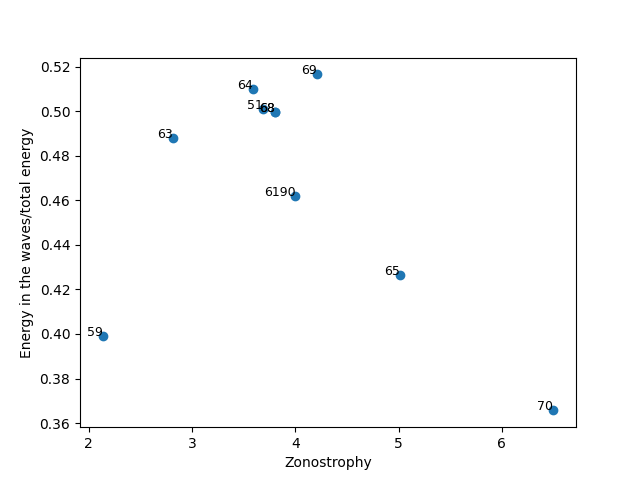

[  59   51   63   64   65   68   70   69   68 6190  901]
[2.13321431 3.6858751  2.81758509 3.5927681  5.01045354 3.80025551
 6.5000993  4.21327242 3.80025551 4.         5.        ]


In [10]:
plt.figure()
plt.scatter(Zo_tab_l[:-1],E_wave_tab[:-1])
# Adding the simulation numbers
for i, txt in enumerate(simu_numbers[:-1]):
    plt.text(Zo_tab_l[i], E_wave_tab[i], str(txt), fontsize=9, ha='right')

plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the waves/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_wave.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

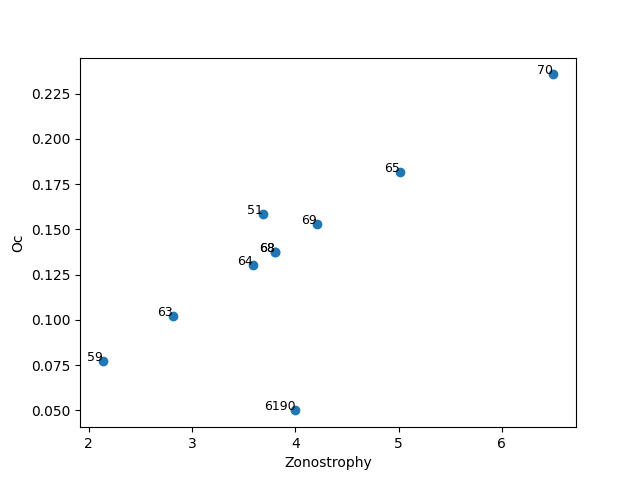

In [11]:
plt.figure()
plt.scatter(Zo_tab_l[:-1],Oc_tab_l[:-1])
# Adding the simulation numbers
for i, txt in enumerate(simu_numbers[:-1]):
    plt.text(Zo_tab_l[i], Oc_tab_l[i], str(txt), fontsize=9, ha='right')

plt.xlabel("Zonostrophy")
plt.ylabel("Oc")
plt.show()


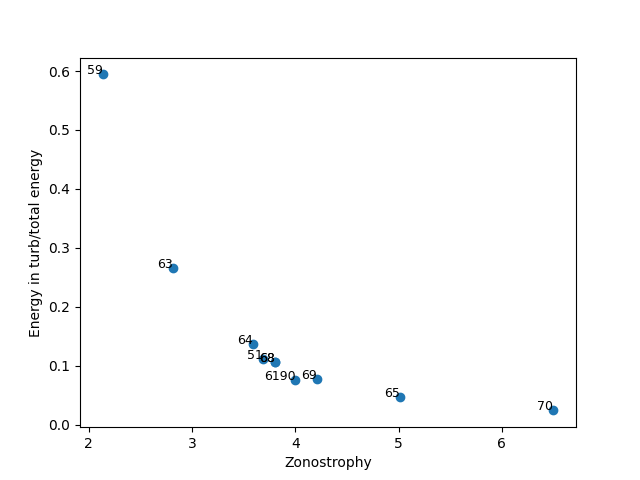

[  59   51   63   64   65   68   70   69   68 6190  901]
[2.13321431 3.6858751  2.81758509 3.5927681  5.01045354 3.80025551
 6.5000993  4.21327242 3.80025551 4.         5.        ]


In [12]:
plt.figure()
plt.scatter(Zo_tab_l[:-1],E_turb_tab[:-1])
# Adding the simulation numbers
for i, txt in enumerate(simu_numbers[:-1]):
    plt.text(Zo_tab_l[i], E_turb_tab[i], str(txt), fontsize=9, ha='right')

plt.xlabel("Zonostrophy")
plt.ylabel("Energy in turb/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_turb.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

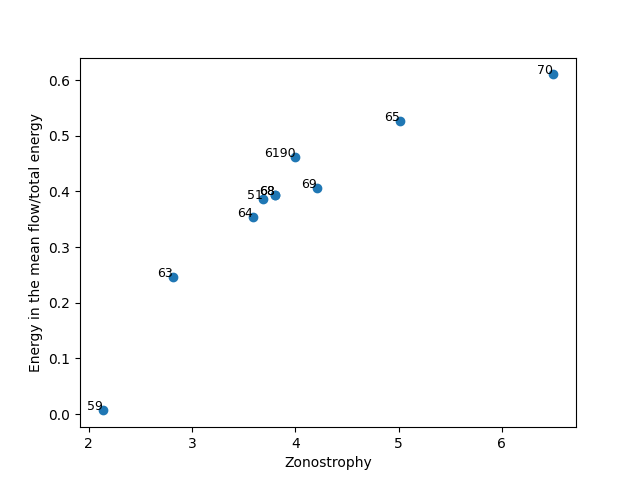

[  59   51   63   64   65   68   70   69   68 6190  901]
[2.13321431 3.6858751  2.81758509 3.5927681  5.01045354 3.80025551
 6.5000993  4.21327242 3.80025551 4.         5.        ]


In [13]:
plt.figure()
plt.scatter(Zo_tab_l[:-1],E_meanflow_tab[:-1])
# Adding the simulation numbers
for i, txt in enumerate(simu_numbers[:-1]):
    plt.text(Zo_tab_l[i], E_meanflow_tab[i], str(txt), fontsize=9, ha='right')

plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the mean flow/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_meanflow.png")
plt.show()
print(simu_numbers)
print(Zo_tab_l)

In [1]:
#simu_numbers=np.array([59,51,63,64,68,70,69,68,619]) #Zonostrophic simu
simu_numbers=np.array([83,317,922,923,9240])
where_list =  ['dahu' for i in range(len(simu_numbers))] #+ ['dahu_downsized']







for i,n in enumerate(simu_numbers):
    #Choose between 'local' or 'dahu'
    where=where_list[i]
    
    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
            Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    #dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})

    dataset=nc.Dataset(Path+filenames[0])

    t=dataset.variables['time'][:]
    # if len(t>498):
    #     t_start=-800
    # else:
    #     t_start=80
    # t=t[t_start:]
    print(len(t))
    x=dataset.variables['x'][:]
    y=dataset.variables['y'][:]
    psi=dataset.variables['psi'][:,0,:,:]
    q=dataset.variables['q'][:,0,:,:]
    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256

        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])


    f0= param['f0']
    beta=param['beta']
    hEkb=param['hEkb']
    dh=param['dh'][0]
    Lx=param['Lx']
    k_f=param['k_f']
    sigma_f=param['sigma_f']
    bc_fac=param['bc_fac']
    nu_hyper=param['nu_hyper']
    n_hyper=param['n_hyper']
    dt_out=param['dt_out']

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)

    k_rhines = beta**0.5/(epsilon/r)**(1/4)
        
    time_start = 100

    psi_data = psi[-time_start:, :, :]
    q_data = q[-time_start:, :, :]

    dx=x[-1]/x.shape[0]
    dy=y[-1]/y.shape[0]

    Lx=x[-1] #Lengh of the domain
    Ly=y[-1] #Width of the domain

    #Calculating the energy
    energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


    enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
    print(np.shape(enstro))
    enstro_mean=np.mean(enstro,axis=(1,2))
    #Calculating the total enstrophy for each snapshots
    enstro_tot=np.sum(enstro,axis=(1,2))


    dx=x[-1]/x.shape[0]
    r=f0*hEkb/(dh*2)


    #energy injectée :
    energy_inj=np.zeros_like(energy_totale)
    energy_inj[:]=sigma_f**2
    energy_diss=-2*energy_totale*r
    #enstro_diss=-2*nu_hyper*enstro_mean

    #Calculating the enerrgy dissipated by hyper-viscosity
    lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)

    if n_hyper==6:
        #palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
        palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
        enstro_diss=-nu_hyper*palenstro_tot 

    #Dans le cas ou l'hyper visocisté est égale à 4:
    elif n_hyper==4:    

        enstro_diss=nu_hyper*np.mean(lap_vorticity*q_data,axis=(1,2))

    mean_enstro_diss=float(np.mean(enstro_diss[:]))
    mean_energy_diss=float(np.mean(energy_diss[:]))
    mean_energy_inj=float(np.mean(energy_inj[:]))

    #computing the error of the energy dissipation
    print("Error =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7)/mean_energy_inj*100,'%')


    ratioE=mean_energy_diss/mean_energy_inj*100
    print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

    plt.figure()

    plt.plot(t[-time_start:],enstro_diss,label='energy dissipated through viscosity')
    plt.plot(t[-time_start:],energy_diss,label='energy disssipated by the drag')
    plt.plot(t[-time_start:],-energy_inj,label='- energy injected')

    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Energy Dissipation')
    plt.title('Evolution of Energy of the simu '+str(simu_name))
    #plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
    plt.show()


NameError: name 'np' is not defined

# Closed Case

la simulation chargée est: dahu_923
depuis: dahu_downsized
shape of psi : (1200, 256, 256)
{'NX': 256, 'NY': 256, 'nl': 1.0, 'Lx': 376.9911184307752, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.0007716049382716048, 'tend': 1576800000000.0, 'dt_out': 0.01}


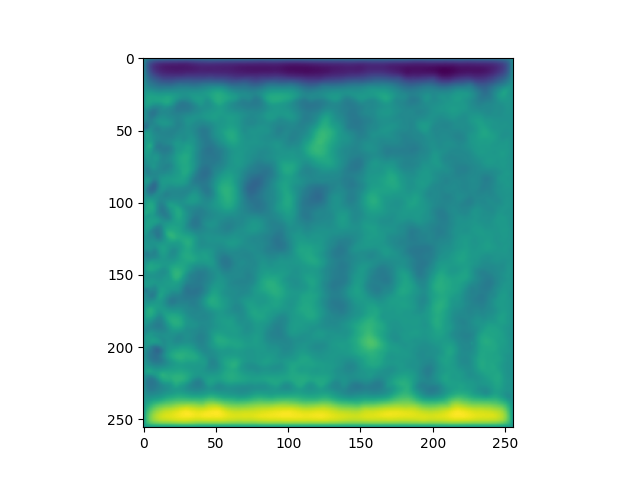

In [3]:


# Number of simulation
n = 923

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu_downsized'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 256
    ny = 256
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



In [2]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = 1/(-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [3]:

def pulsation(psi_mn,t,t_sel):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[t_sel[1]] - t[t_sel[0]]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

In [6]:
# #Batch optimisation 
# time_sel = np.arange(0, len(t), 1, dtype=int)
# pi = np.pi

# def finding_parameters(m_sel, n_sel, time_sel,q, t):
#     """
#     Process a single (m, n) mode and return data for plotting if conditions are met.
#     """
#     # Finding the projection of the field on the mode
#     psi_mn = project_basin(q[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
#     pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    
#     pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    
#     rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    
#     # Conditions to discriminate the modes with wave-like behavior
#     # condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) 
#     # condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) 
#     condition3 = rel_err 

#     return condition1, condition2, condition3

# m_list = np.arange(0, 20, 1) 
# n_list = np.arange(0, 20, 1) 

# condition3_tab = np.zeros((len(n_list), len(m_list)))   

# # Batch processing
# batch_size = 5
# m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

# for batch_idx, m_batch in enumerate(m_batches):
#     print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
#     results = Parallel(n_jobs=-1)(delayed(finding_parameters)(m, n, time_sel, q_prime, t) for m in m_batch for n in n_list)
    
#     for idx, (m, n) in enumerate([(m, n) for m in m_batch for n in n_list]):
#         m_idx = np.where(m_list == m)[0][0]
#         n_idx = np.where(n_list == n)[0][0]
#         condition3_tab[n_idx, m_idx] = results[idx]


In [5]:
#Showing the parameters
epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)
n_rhines=Lx*(k_rhines)/(2*np.pi)


Oc = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
Zo = (beta**2*epsilon/r**5)**(1/20)
print('n_rhines =',n_rhines)    
print("Zono =",Zo)
print("Occupation =",Oc)

n_rhines = 9.793703613355593
Zono = 2.817585085135084
Occupation = 0.10210641851937487


In [6]:
from joblib import Parallel, delayed
import numpy as np

def energy_spectrum(psi_mn,n,m ,L):
    return np.abs(psi_mn)**2 / L**2 * (np.pi**2*(n**2 + m**2)/4)#, psi_mn

def compute_for_mn(m, n, q, time_sel, Lx):
    psi_mn = project_basin(q[time_sel, :, :], m, n, Lx, norm=0) / (-np.pi**2*(n**2 + m**2)/4)
    return energy_spectrum(psi_mn,n,m, Lx)

# Define the range of m and n
m_range = np.arange(1, int(n_rhines*1.3))
n_range = np.arange(1, int(n_rhines*1.3))

time_sel = np.arange(0, len(t), 1, dtype=int)

q_mean = np.mean(q[time_sel, :, :], axis=0)
psi_mean = np.mean(psi[time_sel, :, :], axis=0)
q_prime = q[time_sel, :, :] - q_mean
psi_prime = psi[time_sel, :, :] - psi_mean

# Compute energy spectrum in parallel
results = Parallel(n_jobs=-1)(
    delayed(compute_for_mn)(m, n, q_prime, time_sel, Lx)
    for m in m_range
    for n in n_range
)

# Initialize the E_mn_2D array
E_mn_2D = np.zeros((len(time_sel), len(m_range), len(n_range)))
#Psi_mn_2D=np.zeros((len(time_sel), len(m_range), len(n_range)),dtype='complex')

# Unpack results and place them in the correct position in E_mn_2D
for idx, (E_mn) in enumerate(results):
    m_idx = idx // len(n_range)
    n_idx = idx % len(n_range)
    E_mn_2D[:, m_idx, n_idx] = E_mn
    #Psi_mn_2D[:, m_idx, n_idx] = psi_mn
print("Computation complete.")


KeyboardInterrupt: 

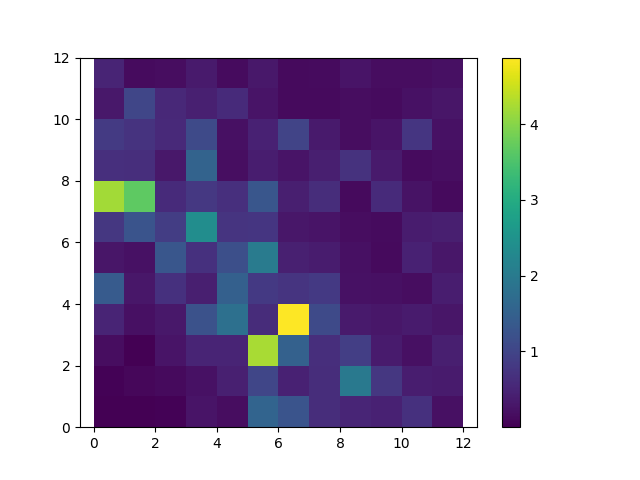

In [9]:
plt.figure()
# plt.subplot(121)
# plt.pcolormesh(np.mean(E_mn_2D,axis=0))
# plt.colorbar()  
# plt.axis('equal')
# plt.subplot(122)
plt.pcolormesh(np.mean(E_mn_2D,axis=0))
plt.colorbar()
plt.axis('equal')
plt.show()


n_rhines 10.0
Energy total 540.9891
Energy of the mean flow [441.3096]
Energy modes 63.36146220507683
Energy in the modes below k_rhines ratio 0.11712152
Energy in the mean flow/total energy [0.8157459]
Energy in the turb/total energy 0.18425399


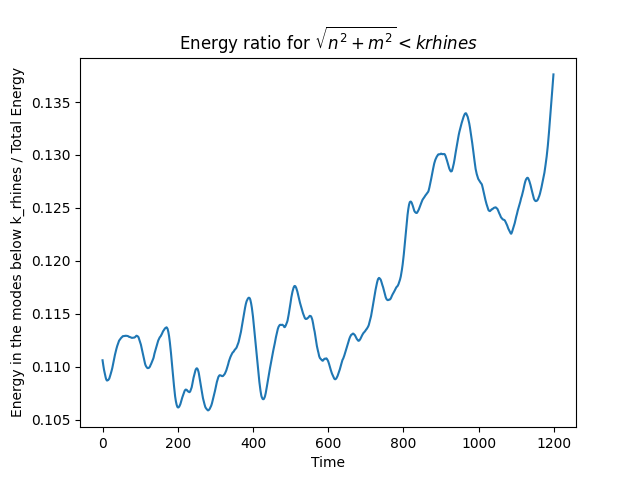

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [10]:
#Computing the energy

N  = np.shape(q)[-1]


M_mat,N_mat = np.meshgrid(m_range,n_range)
mode_mag = np.sqrt(M_mat**2 + N_mat**2)
mask = np.zeros_like(mode_mag)
mask[mode_mag<=n_rhines]=1
print("n_rhines",n_rhines)

# Filter out the energies for k < krhines
energy_filtered = E_mn_2D*mask


# Sum the total energy for the filtered values
total_energy_modes = np.sum(energy_filtered,axis=(1,2))
#Calculating the total energy
dx=x[-1]/x.shape[0]

#Cehcking if the energy is well computed :
total_energy=op.calc_en(psi[time_sel,:,:], q[time_sel,:,:],dx,bc_fac=bc_fac)/Lx**2
total_energy_turb=op.calc_en(psi_prime, q_prime,dx,bc_fac=bc_fac)/Lx**2
total_energy_mean=op.calc_en(psi_mean[None,:,:], q_mean[None,:,:],dx,bc_fac=bc_fac)/Lx**2

total_mean_energy=np.mean(total_energy)
total_mean_energy_modes=np.mean(total_energy_modes,axis=0)
total_mean_turb_energy=np.mean(total_energy_turb,axis=0)

print("Energy total",total_mean_energy.compute())
print("Energy of the mean flow",total_energy_mean.compute())
print("Energy modes",total_mean_energy_modes)
print("Energy in the modes below k_rhines ratio",(total_mean_energy_modes/total_mean_energy).compute())
print("Energy in the mean flow/total energy",(total_energy_mean/total_mean_energy).compute())
print("Energy in the turb/total energy",(total_mean_turb_energy/total_mean_energy).compute())
plt.figure()
plt.plot(time_sel,total_energy_modes/total_energy)
plt.xlabel('Time')
plt.ylabel('Energy in the modes below k_rhines / Total Energy')
plt.title('Energy ratio for $\\sqrt{n^2 + m^2} < krhines$')
plt.savefig('figures/Energy_diags/Energy_total'+str(simu_name)+'.png')
plt.show()

print(np.mean(total_energy_modes/total_energy))

# All Closed Simu

In [16]:
simu_numbers=np.array([83,317,922,923,9240]) #Zonostrophic simu
t_conv=np.array([2000,0,0,0,30])
where_list =  ['dahu' for i in range(len(simu_numbers)-3)] + ['dahu_downsized','dahu_downsized'] + ['dahu']


#Arrays where I will store the parameters:


Zo_tab_l=np.zeros_like(simu_numbers,dtype='float')
Oc_tab_l=np.zeros_like(simu_numbers,dtype='float')
E_modes_tab=np.zeros_like(simu_numbers,dtype='float')
E_meanflow_tab=np.zeros_like(simu_numbers,dtype='float')
E_turb_tab=np.zeros_like(simu_numbers,dtype='float')


f0_tab=np.zeros_like(simu_numbers,dtype='float')
beta_tab=np.zeros_like(simu_numbers,dtype='float')
hEkb_tab=np.zeros_like(simu_numbers,dtype='float')
dh_tab=np.zeros_like(simu_numbers,dtype='float')
Lx_tab=np.zeros_like(simu_numbers,dtype='float')
nx_tab=np.zeros_like(simu_numbers,dtype='float')
ny_tab=np.zeros_like(simu_numbers,dtype='float')
sigma_f_tab=np.zeros_like(simu_numbers,dtype='float')
bc_fac_tab=np.zeros_like(simu_numbers,dtype='float')
nu_hyper_tab=np.zeros_like(simu_numbers,dtype='float')
n_hyper_tab=np.zeros_like(simu_numbers,dtype='float')





for i,n in enumerate(simu_numbers):
    

    # Choose between 'local' or 'dahu' or 'dahu_downsized'
    where = where_list[i]

    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
        Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


    # Load variables in chunks
    t = dataset['time'].data
    x = dataset['x'].data
    y = dataset['y'].data
    psi = dataset['psi'].isel( level=0).data
    q = dataset['q'].isel(level=0).data
    print("shape of psi :",np.shape(psi))


    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256
        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])

    f0 = param['f0']
    beta = param['beta']
    hEkb = param['hEkb']
    dh = param['dh'][0]
    Lx = param['Lx']
    k_f = param['k_f']
    sigma_f = param['sigma_f']
    bc_fac = param['bc_fac']
    nu_hyper = param['nu_hyper']
    n_hyper = param['n_hyper']
    dt_out = param['dt_out']
    



    #Showing the parameters
    epsilon=sigma_f**2
    r=hEkb
    k_rhines=beta**0.5/(epsilon/r)**(1/4)
    n_rhines=Lx*(k_rhines)/(2*np.pi)


    Oc_tab_l[i] = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L   
    Zo_tab_l[i] = (beta**2*epsilon/r**5)**(1/20)


        
    # # Define the range of m and n
    # m_range = np.arange(1, int(n_rhines*1.3))
    # n_range = np.arange(1, int(n_rhines*1.3))

    # time_sel = np.arange(t_conv[i], len(t), 1, dtype=int)

    # q_mean = np.mean(q[time_sel:, :, :], axis=0)
    # psi_mean = np.mean(psi[time_sel:, :, :], axis=0)
    # q_prime = q[time_sel:, :, :] - q_mean
    # psi_prime = psi[time_sel:, :, :] - psi_mean

    # # Compute energy spectrum in parallel
    # results = Parallel(n_jobs=-1)(
    #     delayed(compute_for_mn)(m, n, q_prime, time_sel, Lx)
    #     for m in m_range
    #     for n in n_range
    # )

    # # Initialize the E_mn_2D array
    # E_mn_2D = np.zeros((len(time_sel), len(m_range), len(n_range)))
    # #Psi_mn_2D=np.zeros((len(time_sel), len(m_range), len(n_range)),dtype='complex')

    # # Unpack results and place them in the correct position in E_mn_2D
    # for idx, (E_mn) in enumerate(results):
    #     m_idx = idx // len(n_range)
    #     n_idx = idx % len(n_range)
    #     E_mn_2D[:, m_idx, n_idx] = E_mn
    #     #Psi_mn_2D[:, m_idx, n_idx] = psi_mn
    # print("Computation complete.")

        
    # N  = np.shape(q)[-1]


    # M_mat,N_mat = np.meshgrid(m_range,n_range)
    # mode_mag = np.sqrt(M_mat**2 + N_mat**2)
    # mask = np.zeros_like(mode_mag)
    # mask[mode_mag<=n_rhines]=1
    # print("n_rhines",n_rhines)

    # # Filter out the energies for k < krhines
    # energy_filtered = E_mn_2D*mask


    # # Sum the total energy for the filtered values
    # total_energy_modes = np.sum(energy_filtered,axis=(1,2))
    # #Calculating the total energy
    # dx=x[-1]/x.shape[0]

    # #Cehcking if the energy is well computed :
    # total_energy=op.calc_en(psi[time_sel,:,:], q[time_sel,:,:],dx,bc_fac=bc_fac)/Lx**2
    # total_energy_turb=op.calc_en(psi_prime, q_prime,dx,bc_fac=bc_fac)/Lx**2
    # total_energy_mean=op.calc_en(psi_mean[None,:,:], q_mean[None,:,:],dx,bc_fac=bc_fac)/Lx**2

    # total_mean_energy=np.mean(total_energy)
    # E_meanflow_tab[i]=total_energy_mean.compute()/total_mean_energy.compute()
    # E_modes_tab[i]=np.mean(total_energy_modes,axis=0)/total_mean_energy.compute()
    # E_turb_tab[i]=np.mean(total_energy_turb,axis=0)/total_mean_energy.compute()

    # print("Energy total",total_mean_energy.compute())
    # print("Energy of the mean flow",total_energy_mean.compute())
    
    # print("Energy in the modes below k_rhines ratio",(E_modes_tab[i]/total_mean_energy).compute())
    # print("Energy in the mean flow/total energy",(E_meanflow_tab[i]/total_mean_energy).compute())
    # print("Energy in the turb/total energy",(E_turb_tab[i]/total_mean_energy).compute())




la simulation chargée est: dahu_83
depuis: dahu
shape of psi : (2392, 513, 513)
la simulation chargée est: dahu_317
depuis: dahu
shape of psi : (341, 1025, 1025)
la simulation chargée est: dahu_922
depuis: dahu_downsized
shape of psi : (1200, 256, 256)
la simulation chargée est: dahu_923
depuis: dahu_downsized
shape of psi : (1200, 256, 256)
la simulation chargée est: dahu_9240
depuis: dahu
shape of psi : (89, 2049, 2049)


(4,) ()


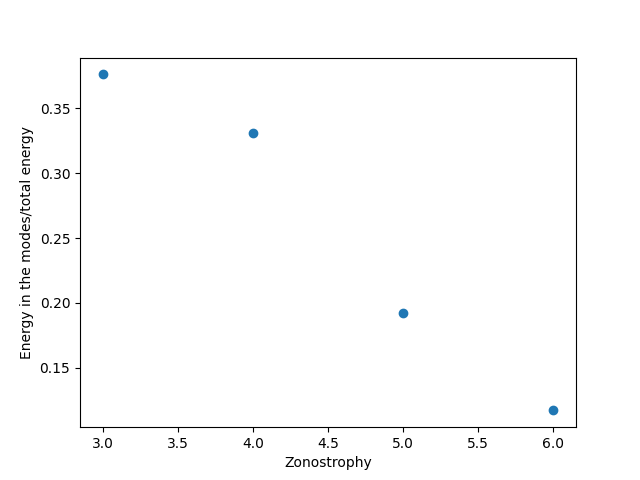

In [ ]:
print(np.shape(E_modes_tab),np.shape(Zo_tab_l))

plt.figure()
plt.scatter([3,4,5,6,7],E_modes_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the modes/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_wave_closed_case_extended.png")
plt.show()


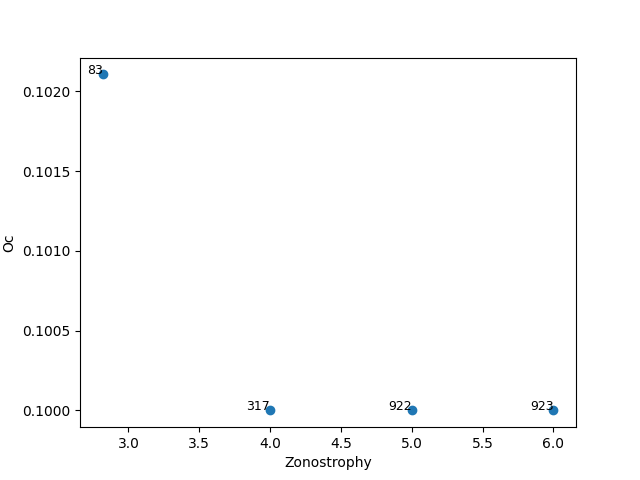

In [17]:
plt.figure()
plt.scatter(Zo_tab_l[:],Oc_tab_l[:-1])
# Adding the simulation numbers
for i, txt in enumerate(simu_numbers[:-1]):
    plt.text(Zo_tab_l[i], Oc_tab_l[i], str(txt), fontsize=9, ha='right')

plt.xlabel("Zonostrophy")
plt.ylabel("Oc")
plt.show()

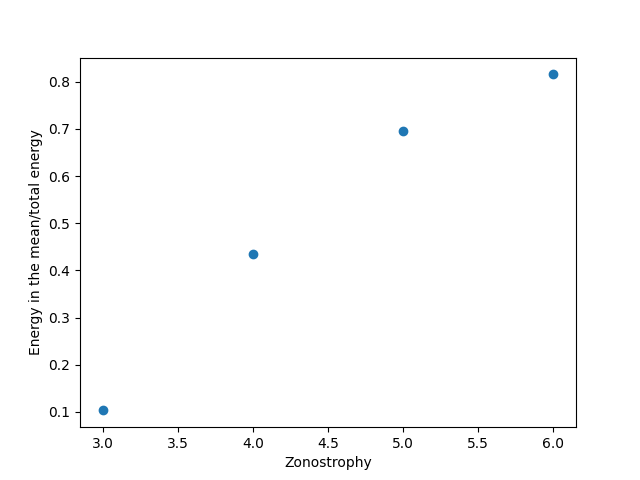

In [ ]:

plt.figure()
plt.scatter([3,4,5,6,7],E_meanflow_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the mean/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_mean_closed_extended.png")
plt.show()

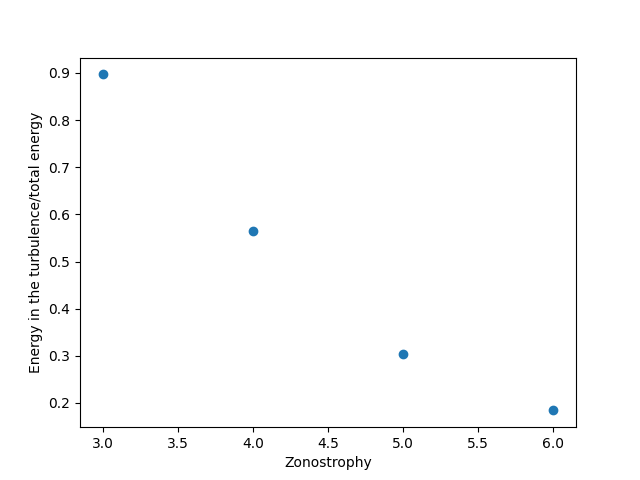

In [ ]:
plt.figure()
plt.scatter([3,4,5,6,7],E_turb_tab)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the turbulence/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_turb_closed_extende.png")
plt.show()

plt.figure()
plt.scatter([3,4,5,6],E_)
plt.xlabel("Zonostrophy")
plt.ylabel("Energy in the modew/total energy")
plt.savefig("figures/Energy_diags/Zonostrophy_energy_wave.png")
plt.show()